# Multiclass Image Classification using CNN

Multiclass image classfication using Convolutional Neural Network impelemented using Pytorch

## Necessary Imports


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive 

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
torch.cuda.empty_cache()
cudnn.benchmark = True 

## Load the Dataset


In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [0]:
transform = transforms.ToTensor()

In [0]:
if not os.path.exists('bleh'):
  os.mkdir('bleh')

In [7]:
train = datasets.CIFAR10(root='bleh', train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, 4), transform, normalize,]))

Files already downloaded and verified


In [8]:
test = datasets.CIFAR10(root='bleh', train=False, download=True, transform=transforms.Compose([transform, normalize,]))

Files already downloaded and verified


In [0]:
train_loader = DataLoader(train, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)

In [0]:
LABELS = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
for images, labels in train_loader:
    break 

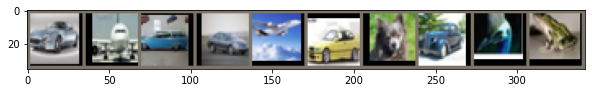

In [12]:
plt.figure(figsize=(10,40))
img = make_grid(images, nrow=16)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img= inv_normalize(img)
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

## Build the CNN model


In [0]:
class CNN(nn.Module):
    def __init__(self, p=0.0):
        # subclass torch's nn Module
        super().__init__()
        
        # Feature extraction layers
        # Convolutional Layer 1 
        self.conv_layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 2
        self.conv_layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 3
        self.conv_layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 4
        self.conv_layer4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Convolutional Layer 5
        self.conv_layer5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.Conv2d(512, 512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.LeakyReLU(negative_slope=0.3, inplace=True),
                                         nn.MaxPool2d(2, 2))
        
        # Output layers
        # Fully Connected Layer for Classifier
        self.dropout = nn.Dropout(p)
        self.fc1 = nn.Linear(1 * 1 * 512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, X):
        # perform convolution using all five convolution layers
        X = self.conv_layer1(X)
        X = self.conv_layer2(X)
        X = self.conv_layer3(X)
        X = self.conv_layer4(X)
        X = self.conv_layer5(X)
        
        # flatten or reshape into a column of extracted features
        X = X.reshape(X.size(0), -1)
        
        # pass through fully connected layer
        X = self.dropout(X)
        X = F.leaky_relu(self.fc1(X), negative_slope=0.3)
        X = self.dropout(X)
        X = F.leaky_relu(self.fc2(X), negative_slope=0.3)
        X = self.fc3(X)
        
        # return softmax probabilities 
        return F.log_softmax(X, dim=1)

## Train the model

In [0]:
model = CNN().cuda()

In [0]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate=0.0003
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

epochs = 60

losses = []
val_losses = []
correct = []
val_correct = []

In [16]:
start_time = time.time()

for e in range(epochs):    
    train_corr = 0
    val_corr = 0
    e_start = time.time()
    # train in batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        # perform single forward pass per batch iteration
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        
        pred = torch.max(y_hat.data, 1)[1]
        batch_corr = (pred == y_train).sum()
        train_corr += batch_corr
        
        # back propagation
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    accuracy = (train_corr.item()*100)/(10*b)
            
    losses.append(loss)
    correct.append(train_corr)
    
    # perform validation every epoch
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            pred = torch.max(y_val, 1)[1]
            val_corr += (pred == y_test).sum()
    
    val_loss = criterion(y_val, y_test)
    val_losses.append(val_loss)
    val_correct.append(val_corr)

    # display training metrics
    if (e % 10 == 0) or (e == 0) or (e == (epochs-1)):
      e_end = time.time()
      print("Epoch {}".format(e+1, b))
      print("Accuracy: {:.4f}  Loss: {:.4f}  Validation Loss: {:.4f}  Duration: {:.2f} minutes".format(accuracy, loss, val_loss, ((e_end-e_start)/60)))

end_time = time.time() - start_time

print("\nTraining Duration {:.4f} minutes".format(end_time/60))
print("GPU memory used : {} kb".format(torch.cuda.memory_allocated()))
print("GPU memory cached : {} kb".format(torch.cuda.memory_cached()))

Epoch 1
Accuracy: 50.3540  Loss: 1.0820  Validation Loss: 0.9997  Duration: 1.25 minutes
Epoch 11
Accuracy: 83.1280  Loss: 0.3852  Validation Loss: 0.4141  Duration: 1.25 minutes
Epoch 21
Accuracy: 87.8460  Loss: 0.4157  Validation Loss: 0.3002  Duration: 1.23 minutes
Epoch 31
Accuracy: 90.4860  Loss: 0.4174  Validation Loss: 0.0936  Duration: 1.23 minutes
Epoch 41
Accuracy: 92.0100  Loss: 0.4260  Validation Loss: 0.0922  Duration: 1.23 minutes
Epoch 51
Accuracy: 93.2440  Loss: 0.3009  Validation Loss: 0.2777  Duration: 1.23 minutes
Epoch 60
Accuracy: 94.0360  Loss: 0.2746  Validation Loss: 0.0507  Duration: 1.25 minutes

Training Duration 74.2129 minutes
GPU memory used : 407718912 kb
GPU memory cached : 559939584 kb


## Evaluation


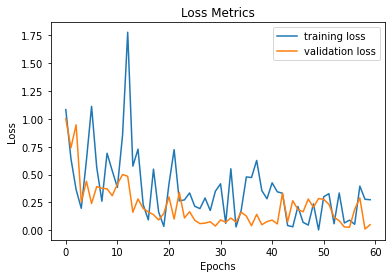

In [17]:
plt.plot(range(epochs), losses, label='training loss')
plt.plot(range(epochs), val_losses, label='validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

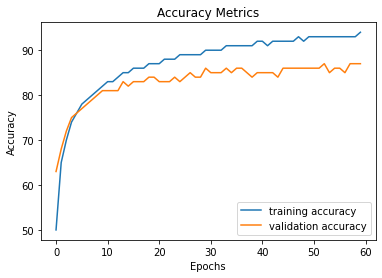

In [18]:
acc = [(train_corr/500) for train_corr in correct]
val_acc = [(test_corr/100) for test_corr in val_correct]
plt.plot(range(epochs), acc, label='training accuracy')
plt.plot(range(epochs), val_acc, label='validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

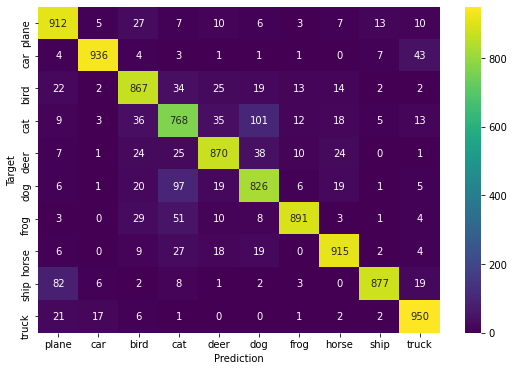

In [19]:
test_load_all = DataLoader(test, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.cuda()
        y_test = y_test.cuda()
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [20]:
print(f"Clasification Report\n\n{classification_report(y_test.view(-1).cpu(), predicted.view(-1).cpu())}")

Clasification Report

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       0.96      0.94      0.95      1000
           2       0.85      0.87      0.86      1000
           3       0.75      0.77      0.76      1000
           4       0.88      0.87      0.87      1000
           5       0.81      0.83      0.82      1000
           6       0.95      0.89      0.92      1000
           7       0.91      0.92      0.91      1000
           8       0.96      0.88      0.92      1000
           9       0.90      0.95      0.93      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Save the model

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/cifar.pt')